### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

**Выводы**:

- WGAN + gradient penalty даёт лучшие результаты по сравнению с WGAN + weight clipping
- для условной генерации работает подход с добавлением эмбеддингов лейблов и последующей конкатенацией
- в целом, для лучших результатов стоит использовать другие архитектуры. Например, свёрточные с Leaky ReLU вместо полносвязных

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

In [ ]:
train = torchvision.datasets.FashionMNIST(
    "fashion_mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [ ]:
28*28

784

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [9]:
generator = Generator()
discriminator = Discriminator()

In [10]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [34]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [48]:
ERRD_x = np.zeros(config.num_epochs)    # вектор ошибок дискриминатора на реальных данных
ERRD_z = np.zeros(config.num_epochs)    # вектор ошибок дискриминатора на фейковых данных
ERRG = np.zeros(config.num_epochs)      # вектор ошибок генератора
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)    # тензор из единичек
        input_data = images.view(images.shape[0], -1)   # вытягиваем изображения в вектор, batch_size x 784
        output = discriminator(input_data)  # batch_size x 784 --> batch_size x 1
        errD_x = criterion(output.squeeze(), label) # ошибка дискриминатора на реальных данных
        ERRD_x[epoch] += errD_x.item()  # записываем ошибку в вектор, индекс - эпоха
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)    # генерируем шум
        fake = generator(noise)     # batch_size x 784, вытянутые в вектор картинки
        label.data.fill_(fake_label)    # тензор из нулей
        output = discriminator(fake.detach()) # batch_size x 784 --> batch_size x1
        errD_z = criterion(output.squeeze(), label) # ошибка дискриминатора на фейковых данных
        ERRD_z[epoch] += errD_z.item()  # # записываем ошибку в вектор, индекс - эпоха
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output.squeeze(), label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print(
                'Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                    epoch+1,
                    iteration+1,
                    errD_x.item(),
                    errD_z.item(),
                    errG.item()
                )
            )

Epoch:1 Iter: 100 errD_x: 0.23 errD_z: 0.13 errG: 2.17
Epoch:1 Iter: 200 errD_x: 0.36 errD_z: 0.08 errG: 2.80
Epoch:1 Iter: 300 errD_x: 0.32 errD_z: 0.11 errG: 2.38
Epoch:1 Iter: 400 errD_x: 0.21 errD_z: 0.07 errG: 2.86
Epoch:1 Iter: 500 errD_x: 0.19 errD_z: 0.07 errG: 2.73
Epoch:1 Iter: 600 errD_x: 0.07 errD_z: 0.06 errG: 3.04
Epoch:1 Iter: 700 errD_x: 0.01 errD_z: 0.05 errG: 3.38
Epoch:1 Iter: 800 errD_x: 0.24 errD_z: 0.21 errG: 1.94
Epoch:1 Iter: 900 errD_x: 0.20 errD_z: 0.14 errG: 2.23
Epoch:1 Iter: 1000 errD_x: 0.36 errD_z: 0.11 errG: 2.31
Epoch:1 Iter: 1100 errD_x: 0.33 errD_z: 0.09 errG: 2.54
Epoch:1 Iter: 1200 errD_x: 0.04 errD_z: 0.12 errG: 2.78
Epoch:1 Iter: 1300 errD_x: 0.19 errD_z: 0.18 errG: 2.08
Epoch:1 Iter: 1400 errD_x: 0.15 errD_z: 0.18 errG: 2.24
Epoch:1 Iter: 1500 errD_x: 0.06 errD_z: 0.11 errG: 2.66
Epoch:1 Iter: 1600 errD_x: 0.40 errD_z: 0.13 errG: 2.56
Epoch:1 Iter: 1700 errD_x: 0.05 errD_z: 0.29 errG: 2.20
Epoch:1 Iter: 1800 errD_x: 0.26 errD_z: 0.13 errG: 2.73
E

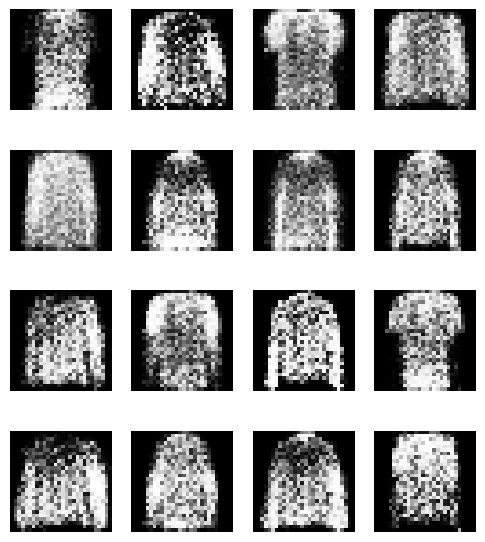

In [49]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN weight clipping

In [71]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100
config.alpha = 0.00005
config.clip = 0.1
config.n_critic = 5

In [72]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)
len(dataloader)

938

In [73]:
batch, label = next(iter(dataloader))
print(f"{batch.size() = }")
print(f"{label.size() = }")

batch.size() = torch.Size([64, 1, 28, 28])
label.size() = torch.Size([64])


In [74]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [75]:
generator = Generator()
discriminator = Discriminator()

In [76]:
optim_G = optim.RMSprop(params=generator.parameters(), lr=config.alpha)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=config.alpha)

In [77]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [80]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)

for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        for _ in range(config.n_critic):
            discriminator.zero_grad()

            # real
            real_data = images.view(images.shape[0], -1)
            real_output = discriminator(real_data)
            errD_x = real_output.mean()
            ERRD_x[epoch] += errD_x.item() / config.n_critic

            # fake
            noise.data.normal_(0, 1)
            fake_data = generator(noise)
            fake_output = discriminator(fake_data.detach())
            errD_z = fake_output.mean()
            ERRD_z[epoch] += errD_z.item() / config.n_critic

            loss_D = -(errD_x - errD_z)

            loss_D.backward()
            optim_D.step()
            for param in discriminator.parameters():
                param.data.clip_(-config.clip, config.clip)

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        fake_output = discriminator(fake_data)
        errG = -fake_output.mean()
        ERRG[epoch] += errG.item()
        errG.backward()
        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print(
                'Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                    epoch+1,
                    iteration+1,
                    errD_x.item(),
                    errD_z.item(),
                    errG.item()
                )
            )

Epoch:1 Iter: 100 errD_x: 11.93 errD_z: 6.60 errG: -6.69
Epoch:1 Iter: 200 errD_x: -7.87 errD_z: -13.39 errG: 13.49
Epoch:1 Iter: 300 errD_x: 25.31 errD_z: 19.74 errG: -19.57
Epoch:1 Iter: 400 errD_x: -17.13 errD_z: -25.67 errG: 26.09
Epoch:1 Iter: 500 errD_x: 7.73 errD_z: 0.99 errG: -0.95
Epoch:1 Iter: 600 errD_x: -1.49 errD_z: -8.71 errG: 8.76
Epoch:1 Iter: 700 errD_x: 18.37 errD_z: 13.81 errG: -12.99
Epoch:1 Iter: 800 errD_x: -12.85 errD_z: -16.13 errG: 15.74
Epoch:1 Iter: 900 errD_x: 7.56 errD_z: 3.74 errG: -3.25
Epoch:2 Iter: 100 errD_x: -2.20 errD_z: -6.40 errG: 5.77
Epoch:2 Iter: 200 errD_x: 16.04 errD_z: 8.86 errG: -9.36
Epoch:2 Iter: 300 errD_x: 13.99 errD_z: 8.81 errG: -8.65
Epoch:2 Iter: 400 errD_x: -17.27 errD_z: -21.63 errG: 21.60
Epoch:2 Iter: 500 errD_x: 23.17 errD_z: 17.48 errG: -17.72
Epoch:2 Iter: 600 errD_x: 2.33 errD_z: -1.68 errG: 1.46
Epoch:2 Iter: 700 errD_x: -5.57 errD_z: -8.19 errG: 7.89
Epoch:2 Iter: 800 errD_x: -10.90 errD_z: -13.03 errG: 12.35
Epoch:2 Iter: 

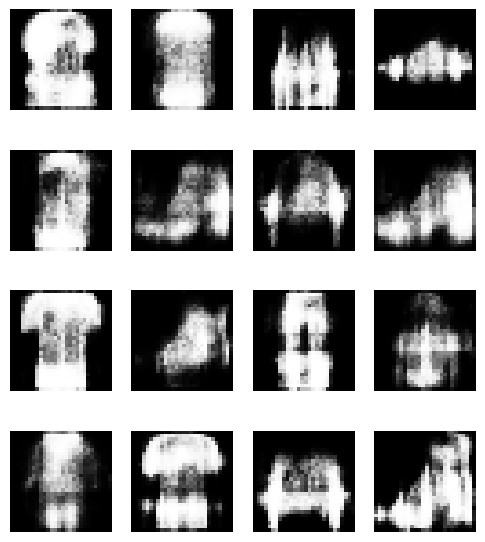

In [82]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN gradient penalty

In [133]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100
config.penalty_coef = 10
config.n_critic = 5
config.alpha = 0.0001
config.beta_1 = 0
config.beta_2 = 0.9

In [143]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, drop_last=True)
len(dataloader)

937

In [144]:
batch, label = next(iter(dataloader))
print(f"{batch.size() = }")
print(f"{label.size() = }")

batch.size() = torch.Size([64, 1, 28, 28])
label.size() = torch.Size([64])


In [145]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [146]:
generator = Generator()
discriminator = Discriminator()

In [147]:
optim_G = optim.Adam(
    params=generator.parameters(),
    lr=config.alpha,
    betas=(config.beta_1, config.beta_2)
)

optim_D = optim.Adam(
    params=discriminator.parameters(),
    lr=config.alpha,
    betas=(config.beta_1, config.beta_2)
)

In [148]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [149]:
def compute_gradient_penalty(real_data, fake_data, discriminator):
    batch_size, hid_size = real_data.shape
    epsilon = torch.FloatTensor(batch_size, 1,).uniform_(0,1)
    epsilon = epsilon.expand(batch_size, hid_size)

    input = epsilon * real_data + (1 - epsilon) * fake_data
    input = Variable(input, requires_grad=True)

    output = discriminator(input)
    output_grads = torch.autograd.grad(
        outputs=output,
        inputs=input,
        grad_outputs=torch.ones(output.size()),
        create_graph=True,
        retain_graph=True
    )[0]

    penalty = ((output_grads.norm(p=2, dim=1) - 1)**2).mean()
    return penalty

In [150]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)

for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        for _ in range(config.n_critic):
            discriminator.zero_grad()

            # real
            real_data = images.view(images.shape[0], -1)
            real_output = discriminator(real_data)
            errD_x = real_output.mean()
            ERRD_x[epoch] += errD_x.item() / config.n_critic

            # fake
            noise.data.normal_(0, 1)
            fake_data = generator(noise)
            fake_output = discriminator(fake_data.detach())
            errD_z = fake_output.mean()
            ERRD_z[epoch] += errD_z.item() / config.n_critic

            # penalty
            loss_D = -(errD_x - errD_z) + config.penalty_coef * compute_gradient_penalty(
                real_data,
                fake_data,
                discriminator
            )

            loss_D.backward()
            optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        fake_output = discriminator(fake_data)
        errG = -fake_output.mean()
        ERRG[epoch] += errG.item()
        errG.backward()
        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print(
                'Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                    epoch+1,
                    iteration+1,
                    errD_x.item(),
                    errD_z.item(),
                    errG.item()
                )
            )

Epoch:1 Iter: 100 errD_x: -1.11 errD_z: -9.74 errG: 9.84
Epoch:1 Iter: 200 errD_x: 3.52 errD_z: -3.88 errG: 3.87
Epoch:1 Iter: 300 errD_x: 3.71 errD_z: -2.83 errG: 3.00
Epoch:1 Iter: 400 errD_x: 6.41 errD_z: 0.18 errG: -0.10
Epoch:1 Iter: 500 errD_x: 6.10 errD_z: 0.68 errG: -0.94
Epoch:1 Iter: 600 errD_x: 6.32 errD_z: 1.39 errG: -1.44
Epoch:1 Iter: 700 errD_x: 5.93 errD_z: 1.58 errG: -1.79
Epoch:1 Iter: 800 errD_x: 4.63 errD_z: 0.75 errG: -0.78
Epoch:1 Iter: 900 errD_x: 4.45 errD_z: 0.24 errG: -0.04
Epoch:2 Iter: 100 errD_x: 5.66 errD_z: 1.61 errG: -1.51
Epoch:2 Iter: 200 errD_x: 4.39 errD_z: 0.98 errG: -0.96
Epoch:2 Iter: 300 errD_x: 4.22 errD_z: 0.43 errG: -0.47
Epoch:2 Iter: 400 errD_x: 3.99 errD_z: 0.43 errG: -0.42
Epoch:2 Iter: 500 errD_x: 3.52 errD_z: 0.04 errG: -0.34
Epoch:2 Iter: 600 errD_x: 4.26 errD_z: -0.10 errG: 0.65
Epoch:2 Iter: 700 errD_x: 3.55 errD_z: -0.18 errG: 0.33
Epoch:2 Iter: 800 errD_x: 2.55 errD_z: -0.50 errG: 0.47
Epoch:2 Iter: 900 errD_x: 3.37 errD_z: 0.21 err

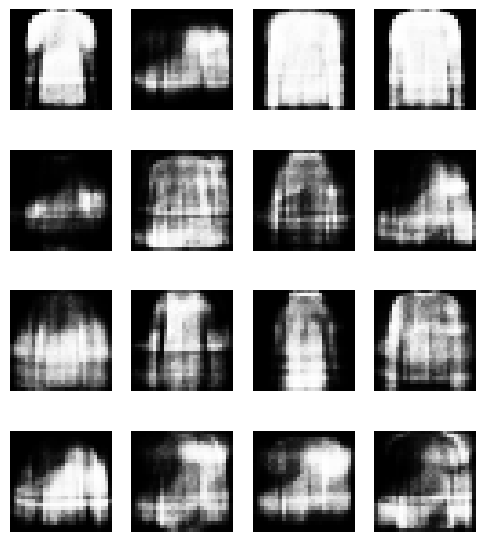

In [151]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN condition

In [170]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100
config.n_critic = 5
config.clip = 0.1
config.alpha = 0.0001
config.beta_1 = 0
config.beta_2 = 0.9

In [171]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, drop_last=True)
len(dataloader)

937

In [172]:
batch, label = next(iter(dataloader))
print(f"{batch.size() = }")
print(f"{label.size() = }")

batch.size() = torch.Size([64, 1, 28, 28])
label.size() = torch.Size([64])


In [173]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + 200, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )
        self.label_embeddings = nn.Embedding(10, 200)

    def forward(self, x, labels):
        label_emb = self.label_embeddings(labels)
        x = torch.cat((x, label_emb), dim=1)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 200, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            # nn.Sigmoid()
        )
        self.label_embeddings = nn.Embedding(10, 200)

    def forward(self, x, labels):
        label_emb = self.label_embeddings(labels)
        x = torch.cat((x, label_emb), dim=1)
        return self.model(x)

In [174]:
generator = Generator()
discriminator = Discriminator()

In [175]:
optim_G = optim.Adam(
    params=generator.parameters(),
    lr=config.alpha,
    betas=(config.beta_1, config.beta_2)
)

optim_D = optim.Adam(
    params=discriminator.parameters(),
    lr=config.alpha,
    betas=(config.beta_1, config.beta_2)
)

In [176]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [177]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)

for epoch in range(config.num_epochs):
    for iteration, (images, labels) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        for _ in range(config.n_critic):
            discriminator.zero_grad()

            # real
            real_data = images.view(images.shape[0], -1)
            real_output = discriminator(real_data, labels)
            errD_x = real_output.mean()
            ERRD_x[epoch] += errD_x.item() / config.n_critic

            # fake
            noise.data.normal_(0, 1)
            fake_data = generator(noise, labels)
            fake_output = discriminator(fake_data.detach(), labels)
            errD_z = fake_output.mean()
            ERRD_z[epoch] += errD_z.item() / config.n_critic

            loss_D = -(errD_x - errD_z)

            loss_D.backward()
            optim_D.step()
            for param in discriminator.parameters():
                param.data.clip_(-config.clip, config.clip)

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        fake_output = discriminator(fake_data, labels)
        errG = -fake_output.mean()
        ERRG[epoch] += errG.item()
        errG.backward()
        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print(
                'Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                    epoch+1,
                    iteration+1,
                    errD_x.item(),
                    errD_z.item(),
                    errG.item()
                )
            )

Epoch:1 Iter: 100 errD_x: -14.78 errD_z: -48.94 errG: 49.66
Epoch:1 Iter: 200 errD_x: -49.52 errD_z: -53.58 errG: 53.70
Epoch:1 Iter: 300 errD_x: 28.36 errD_z: 15.58 errG: -16.06
Epoch:1 Iter: 400 errD_x: 17.47 errD_z: 6.85 errG: -6.63
Epoch:1 Iter: 500 errD_x: 1.38 errD_z: -3.84 errG: 3.99
Epoch:1 Iter: 600 errD_x: 7.12 errD_z: 3.88 errG: -4.21
Epoch:1 Iter: 700 errD_x: -0.52 errD_z: -4.01 errG: 4.42
Epoch:1 Iter: 800 errD_x: 8.90 errD_z: 6.15 errG: -6.42
Epoch:1 Iter: 900 errD_x: -6.05 errD_z: -10.38 errG: 10.91
Epoch:2 Iter: 100 errD_x: 14.73 errD_z: 11.16 errG: -11.67
Epoch:2 Iter: 200 errD_x: 5.40 errD_z: 1.51 errG: -0.79
Epoch:2 Iter: 300 errD_x: 5.16 errD_z: 0.03 errG: -0.63
Epoch:2 Iter: 400 errD_x: 16.68 errD_z: 9.25 errG: -8.57
Epoch:2 Iter: 500 errD_x: 7.75 errD_z: -0.58 errG: 0.89
Epoch:2 Iter: 600 errD_x: 4.27 errD_z: -4.65 errG: 5.06
Epoch:2 Iter: 700 errD_x: 3.95 errD_z: -5.94 errG: 6.21
Epoch:2 Iter: 800 errD_x: 11.72 errD_z: 2.99 errG: -3.03
Epoch:2 Iter: 900 errD_x: 1

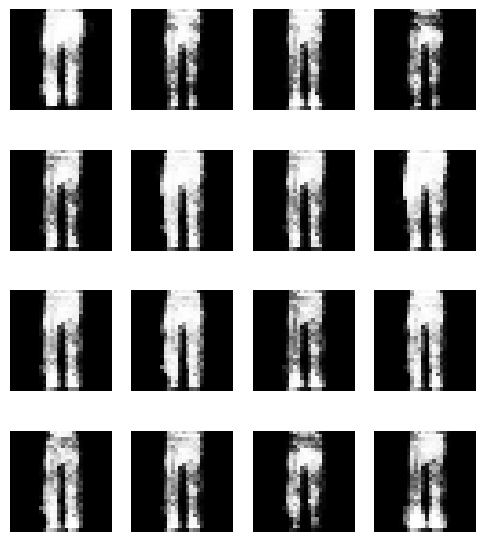

In [183]:
noise.data.normal_(0, 1)
labels = torch.ones(noise.data.normal_(0, 1).shape[0], dtype=torch.long)
fake = generator(noise, labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

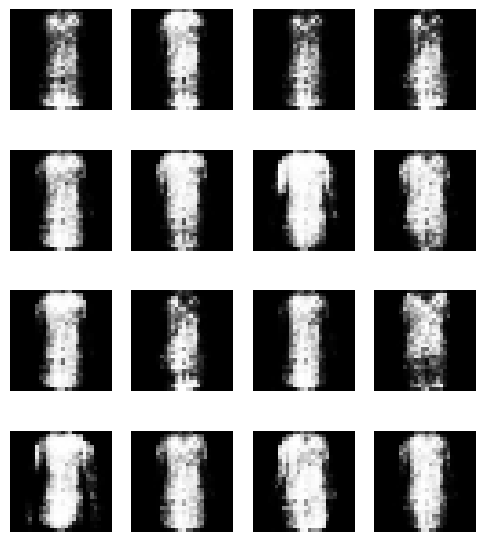

In [185]:
noise.data.normal_(0, 1)
labels = torch.ones(noise.data.normal_(0, 1).shape[0], dtype=torch.long) * 3
fake = generator(noise, labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

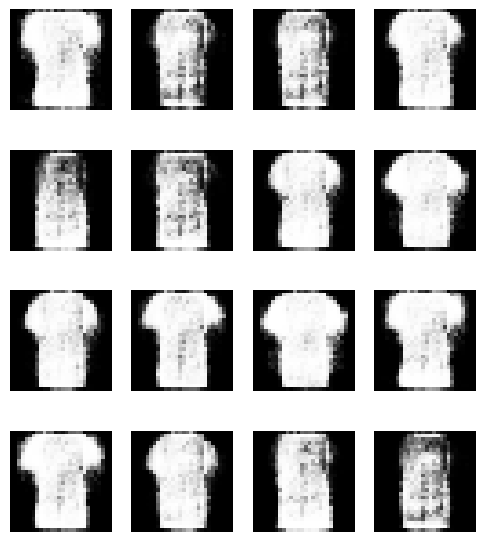

In [186]:
noise.data.normal_(0, 1)
labels = torch.zeros(noise.data.normal_(0, 1).shape[0], dtype=torch.long)
fake = generator(noise, labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')